## Ocean Biogeochemical Dynamics Lab, Spring 2021
### Introduction to Python and Jupyter Notebooks
### Importing and cleaning data

In [3]:
# This is how you make a comment!
# Always annotate your code so you know what you did and why
# I promise you won't remember the details when it comes time to write up the results

# Ideally, you are also using some kind of version control like github
# version control allows you to track changes in your code, revert back if you need to,
# or even branch a piece of code off into two independent versions.
# Also great for collaborative projects

# Always start by importing the tools you will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import seaborn as sns # this will change the look of pandas plots too
import cartopy.crs as ccrs
import cartopy.feature
%matplotlib inline 
# this forces matplotlib to print figures out here when you make plots

# Press Shift + Enter to "run" this cell and move on to the next one
# Press Option + Enter to add run and an empty cell below this one 

In [4]:
# Start a new "cell" when you transition to a new step in your code
# This allows you to run your code in chunks and better troubleshoot where issues might be.

# Bring in the dataset you will need
# This code imports a SOCCOM biogeochemical Argo Float "snapshot" dataset from December 2020 for one float.
# The entire .zip file with all floats can be downloaded here: 
# https://library.ucsd.edu/dc/object/bb94601812 as the "LIAR High resolution ODV format"
# It is easiest to place the file in the same directory where you will keep this code

# Download, and then go and unzip that file. What's inside?


# In this case, a "snapshot" means that the data have been quality-controlled 
# and archived with a "doi" or digital object identifier.
# It is important to use a dataset that has been "frozen" somewhere and to document 
# every step you take from that point on, including cleaning, reformatting, renaming, unit conversions,
# and calculations.

# We want to use Pandas' built-in read_csv function to import the data file into a pandas
# data frame called "flt"

flt=pd.read_csv('SOCCOM_HiResQC_LIAR_22Dec2020_odvtxt/9091SOOCN_HRQC.TXT', error_bad_lines=False)
# There are a bunch of other input options for this function, and you can see them by
# pressing "tab" inside the function



b'Skipping line 27: expected 1 fields, saw 3\nSkipping line 30: expected 1 fields, saw 3\nSkipping line 32: expected 1 fields, saw 2\nSkipping line 33: expected 1 fields, saw 6\nSkipping line 34: expected 1 fields, saw 2\nSkipping line 35: expected 1 fields, saw 2\nSkipping line 39: expected 1 fields, saw 3\nSkipping line 41: expected 1 fields, saw 3\nSkipping line 43: expected 1 fields, saw 3\nSkipping line 44: expected 1 fields, saw 2\nSkipping line 45: expected 1 fields, saw 3\nSkipping line 47: expected 1 fields, saw 2\nSkipping line 49: expected 1 fields, saw 2\nSkipping line 51: expected 1 fields, saw 2\nSkipping line 52: expected 1 fields, saw 5\nSkipping line 56: expected 1 fields, saw 3\nSkipping line 58: expected 1 fields, saw 4\nSkipping line 62: expected 1 fields, saw 3\nSkipping line 67: expected 1 fields, saw 4\nSkipping line 83: expected 1 fields, saw 4\n'


In [5]:
# Python doesn't typically spit out the results unless you ask for them.
# This is how you look at just the "head" the flt dataframe
flt.head()

,//0
0,//<Encoding>UTF-8</Encoding>
1,//File updated on 12/21/2020 18:36
2,//!! ADJUSTED DATA FILE !!
3,//WMO ID: 5904184
4,//Univ. of Washington ID: 9091


In [6]:
# This is how you look at just the whole flt dataframe
flt

,//0
0,//<Encoding>UTF-8</Encoding>
1,//File updated on 12/21/2020 18:36
2,//!! ADJUSTED DATA FILE !!
3,//WMO ID: 5904184
4,//Univ. of Washington ID: 9091
...,...
84596,5904184\t153\tC\t07/18/2018\t23:57\t217.015\t-...
84597,5904184\t153\tC\t07/18/2018\t23:57\t217.015\t-...
84598,5904184\t153\tC\t07/18/2018\t23:57\t217.015\t-...
84599,5904184\t153\tC\t07/18/2018\t23:57\t217.015\t-...


In [7]:
# Clearly something is wrong. We didn't get any meaningful data! Why? Because those are comment lines in the data file.
# Let's try telling read_cvs what a comment looks like
flt=pd.read_csv('SOCCOM_HiResQC_LIAR_22Dec2020_odvtxt/9091SOOCN_HRQC.TXT', error_bad_lines=False, comment='/')
# There are a bunch of other input options for this function, and you can see them by
# typing a comma and then pressing "tab" from inside the function parentheses
# Run this new read_csv function and look at the header of the new flt dataframe
# by running this code you overwrite your last flt dataframe
flt.head()

,Cruise\tStation\tType\tmon
0,5904184\t1\tC\t04
1,5904184\t1\tC\t04
2,5904184\t1\tC\t04
3,5904184\t1\tC\t04
4,5904184\t1\tC\t04


In [8]:
# We are getting warmer, we now see a more meaningful header and some data, but what are those "\t"s?

# Those are tab delimiters/separators. CSV means comma separated values and TSV means tab separated values.
# The files typically look identical and the delimiters are invisible when viewed from excel or a text editor.
# So now we need to tell read_csv what the delimiter is.
flt=pd.read_csv('SOCCOM_HiResQC_LIAR_22Dec2020_odvtxt/9091SOOCN_HRQC.TXT', error_bad_lines=False, 
                comment='/', delimiter='\t')
# simply press enter in the code to continue your code onto a new line if you're inside a parentheses
# Look at the header
flt.head()

,Cruise,Station,Type,mon
0,5904184,1,C,4
1,5904184,1,C,4
2,5904184,1,C,4
3,5904184,1,C,4
4,5904184,1,C,4


In [9]:
# That looks better, now let's look at the info for the file to see more:
flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84537 entries, 0 to 84536
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Cruise   84537 non-null  int64 
 1   Station  84537 non-null  int64 
 2   Type     84537 non-null  object
 3   mon      84537 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.6+ MB


In [10]:
# We are getting many rows of data, but only four columns. Why? 

# Because the "comment" character used in these float data files is two forward slashes "//"
# Unfortunately, Pandas read_csv can only handle one character in the comment field.

# Because we entered '/' as the comment character, we also lose everything after any '/'
# In this case, we lose everything after "mon" in the header row and after the month number in all data rows
# Basically, you should never use your delimiter/separator character anywhere else in your data file.

In [11]:
# To work around this, we will first open the file and replace all instances of '//' with '#'
# I checked to make sure "#" isn't used in the actual data anywhere

# input file
fin = open('SOCCOM_HiResQC_LIAR_22Dec2020_odvtxt/9091SOOCN_HRQC.TXT','rt',encoding='UTF-8')

# output file to which we will write the result
fout = open('fltrem.txt','wt')

# This how you define a function. 
# You write functions in order to generalize a process so you can use it over and over
# without having to rewrite each time.

# for each line in the input file
for line in fin:
    # red and replace the string and write to the output file
    fout.write(line.replace('//','#'))
# close the files
fin.close()
fout.close()

In [12]:
flt=pd.read_csv('fltrem.txt',delimiter='\t',comment='#',na_values=-1E10)
# Now I've also added a term to tell read_csv what the "not a number" value is in the file
# NA values are used to fill in where there is either no data or sometimes bad data which has been removed
# They used an absurdly small number which is not zero, but is so small 
# that you would never get the value from a sensor. You could also use an absurdly large number

In [13]:
#take a look at the info for the flt dataframe you have made
flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84537 entries, 0 to 84536
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cruise               84537 non-null  int64  
 1   Station              84537 non-null  int64  
 2   Type                 84537 non-null  object 
 3   mon/day/yr           84537 non-null  object 
 4   hh:mm                84537 non-null  object 
 5   Lon [°E]             84537 non-null  float64
 6   Lat [°N]             84537 non-null  float64
 7   QF                   84537 non-null  int64  
 8   Pressure[dbar]       84384 non-null  float64
 9   QF.1                 84384 non-null  float64
 10  Temperature[°C]      84384 non-null  float64
 11  QF.2                 84384 non-null  float64
 12  Salinity[pss]        84384 non-null  float64
 13  QF.3                 84384 non-null  float64
 14  Sigma_theta[kg/m^3]  84384 non-null  float64
 15  QF.4                 84384 non-null 

In [14]:
# look at the head of the data frame
flt.head()

,Cruise,Station,Type,mon/day/yr,hh:mm,Lon [°E],Lat [°N],QF,Pressure[dbar],QF.1,...,pHinsitu[Total],QF.14,pH25C[Total],QF.15,TALK_LIAR[µmol/kg],QF.16,DIC_LIAR[µmol/kg],QF.17,pCO2_LIAR[µatm],QF.18
0,5904184,1,C,04/03/2014,22:50,209.965,-63.973,0,1399.38,0.0,...,7.8557,0.0,7.5605,0.0,2353.0,0.0,2269.0,0.0,533.2,0.0
1,5904184,1,C,04/03/2014,22:50,209.965,-63.973,0,1298.38,0.0,...,7.8584,0.0,7.5598,0.0,2351.0,0.0,2268.0,0.0,535.8,0.0
2,5904184,1,C,04/03/2014,22:50,209.965,-63.973,0,1199.53,0.0,...,7.8614,0.0,7.5594,0.0,2354.0,0.0,2271.0,0.0,538.8,0.0
3,5904184,1,C,04/03/2014,22:50,209.965,-63.973,0,1098.49,0.0,...,7.8650,0.0,7.5595,0.0,2355.0,0.0,2272.0,0.0,540.8,0.0
4,5904184,1,C,04/03/2014,22:50,209.965,-63.973,0,999.27,0.0,...,7.8688,0.0,7.5600,0.0,2355.0,0.0,2272.0,0.0,542.1,0.0


In [15]:
# Notice that the date format is in a text string, and we will want it in a number format
flt['date']=pd.to_datetime(flt['mon/day/yr']+' '+ flt['hh:mm'])
flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84537 entries, 0 to 84536
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Cruise               84537 non-null  int64         
 1   Station              84537 non-null  int64         
 2   Type                 84537 non-null  object        
 3   mon/day/yr           84537 non-null  object        
 4   hh:mm                84537 non-null  object        
 5   Lon [°E]             84537 non-null  float64       
 6   Lat [°N]             84537 non-null  float64       
 7   QF                   84537 non-null  int64         
 8   Pressure[dbar]       84384 non-null  float64       
 9   QF.1                 84384 non-null  float64       
 10  Temperature[°C]      84384 non-null  float64       
 11  QF.2                 84384 non-null  float64       
 12  Salinity[pss]        84384 non-null  float64       
 13  QF.3                 84384 non-

In [16]:
# Notice the QF or Quality Flag columns. These tell us which data are good, questionable, and bad.
# We only want to use good data. How can we tell which data are good?
# Go back to the text file comments. We should remove bad and questionable data flagged 4 and 3, respectively.
# We will do this later.

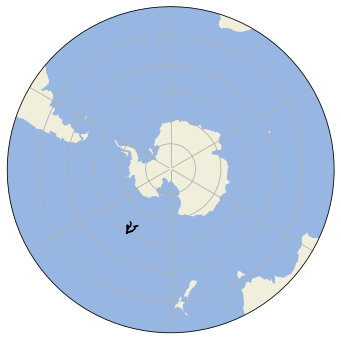

In [17]:
# Make a map using cartopy (basemap is deprecated!)

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180,180,-90,-30],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

plt.plot(flt['Lon [°E]'],flt['Lat [°N]'],color='Black',transform=ccrs.PlateCarree())

plt.savefig('SPstereo.pdf')
plt.savefig('SPstereo.png')

plt.show()

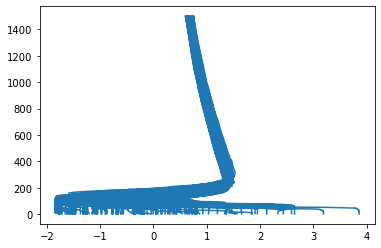

In [18]:
# Let's make a quick plot of temperature vs pressure
plt.plot(flt['Temperature[°C]'],flt['Pressure[dbar]'])
# This method is quick and dirty but doesn't give us much control over the figure

Text(0, 0.5, 'Pressure [dbar]')

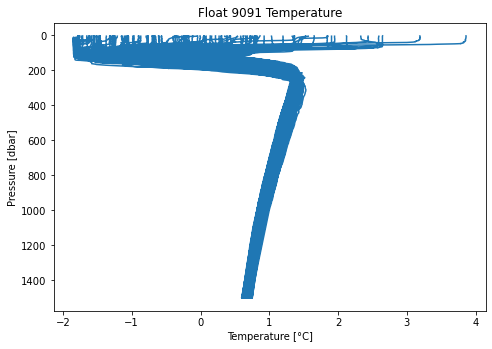

In [19]:
# Something funny? 
# We want to invert the axis and add some labels

# Now we will use the object-oriented programming to have more control over the plot
fig = plt.figure()
# this allows you to create multiple axes
axes1= fig.add_axes([0, 0, 1, 1])
axes1.plot(flt['Temperature[°C]'],flt['Pressure[dbar]'])
axes1.set_title('Float 9091 Temperature') # There are ways to make the figure title dynamic,
# i.e. adapts to the float number
axes1.invert_yaxis()
axes1.set_xlabel('Temperature [°C]')
axes1.set_ylabel('Pressure [dbar]')
# if you wanted to add a subplot you would add it like this
#axes2= fig.add_axes([.7, .7, .2, .2])

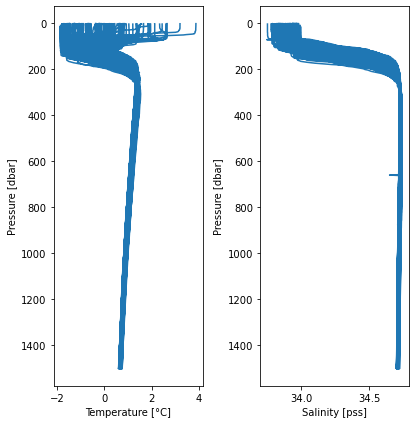

In [20]:
# Can also use subplots function
fig,axes = plt.subplots(nrows = 1, ncols = 2,figsize=(6,6))
# if you have many subplots and some overlap, use tight_layout, or you can leave it 
# at the end of all of your plot statements
# plt.tight_layout()

axes[0].plot(flt['Temperature[°C]'],flt['Pressure[dbar]'])
#axes[0].set_title('Temperature')
axes[0].invert_yaxis()
axes[0].set_ylabel('Pressure [dbar]')
axes[0].set_xlabel('Temperature [°C]')

axes[1].plot(flt['Salinity[pss]'],flt['Pressure[dbar]'])
#axes[1].set_title('Salinity')
axes[1].invert_yaxis()
axes[1].set_ylabel('Pressure [dbar]')
axes[1].set_xlabel('Salinity [pss]')

plt.tight_layout()
# This is the first figure we're saving. We have given it a name, a type, and a dpi or
# dots per inch which is resolution
fig.savefig('F9091TS.png', dpi = 200)

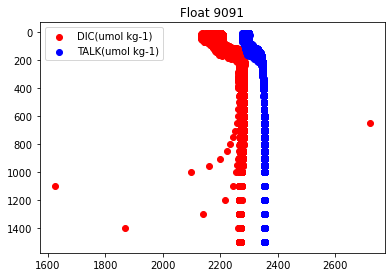

In [21]:
# Now let's plot multiple things on one axis
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, .8, .8])
ax.scatter(flt['DIC_LIAR[µmol/kg]'],flt['Pressure[dbar]'],label = 'DIC(umol kg-1)', color = 'red')
ax.scatter(flt['TALK_LIAR[µmol/kg]'],flt['Pressure[dbar]'],label = 'TALK(umol kg-1)', color = 'blue') 
# for color you can also put in an RGB hex code
ax.legend(loc=0) # 0 is for the "best" location
ax.set_title('Float 9091')# Figure out how to have this be dynamic and change with the float number
ax.invert_yaxis()
fig.savefig('F9091DICTALK.png', dpi = 200)

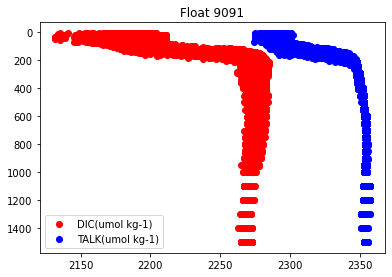

In [22]:
# This is where we left off in class on Jan 22

# We see funny data here. Maybe we need to use the quality flags now
# Keep only good data flagged zero and replace rest with 'nan' which is "not a number"
flt['DIC_LIAR[µmol/kg]'] = np.where(flt['QF.17'] == 0 , flt['DIC_LIAR[µmol/kg]'], np.nan)

# Now replot that same figure
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, .8, .8])
ax.scatter(flt['DIC_LIAR[µmol/kg]'],flt['Pressure[dbar]'],label = 'DIC(umol kg-1)', color = 'red')
ax.scatter(flt['TALK_LIAR[µmol/kg]'],flt['Pressure[dbar]'],label = 'TALK(umol kg-1)', color = 'blue') 
# for color you can also put in an RGB hex code
ax.legend(loc=0) # 0 is for the "best" location
ax.set_title('Float 9091')# Figure out how to have this be dynamic and change with the float number
ax.invert_yaxis()
fig.savefig('F9091DICTALKQC.png', dpi = 200)

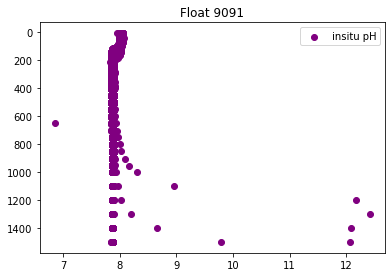

In [23]:
# If we use "plot" we get a HUGE gap in the mid-water column. 
# The BGC Data are lower resolution so we need to use scatter.
fig = plt.figure()
# this allows you to create multiple axes
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt['pHinsitu[Total]'],flt['Pressure[dbar]'],label = 'insitu pH',color='purple')
axes1.legend()
axes1.set_title('Float 9091')
axes1.invert_yaxis()
fig.savefig('F9091pH.png', dpi = 200)

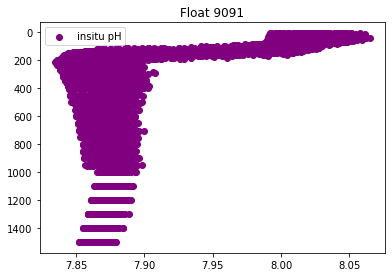

In [24]:
# Keep only good data flagged zero and replace rest with 'nan' which is "not a number"
flt['pHinsitu[Total]'] = np.where(flt['QF.14'] == 0 , flt['pHinsitu[Total]'], np.nan)
fig = plt.figure()
# this allows you to create multiple axes
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt['pHinsitu[Total]'],flt['Pressure[dbar]'],label = 'insitu pH',color='purple')
axes1.legend()
axes1.set_title('Float 9091')
axes1.invert_yaxis()
fig.savefig('F9091pHQC.png', dpi = 200)

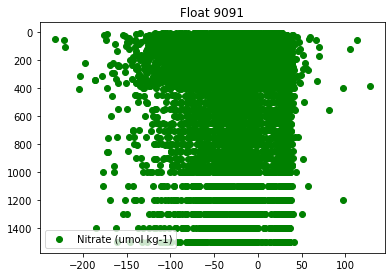

In [25]:
# is nitrate there?
fig = plt.figure()
# this allows you to create multiple axes
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt['Nitrate[µmol/kg]'],flt['Pressure[dbar]'],label = 'Nitrate (umol kg-1)',color='green')
axes1.legend()
axes1.set_title('Float 9091')
axes1.invert_yaxis()
fig.savefig('F9091Nitrate.png', dpi = 200)

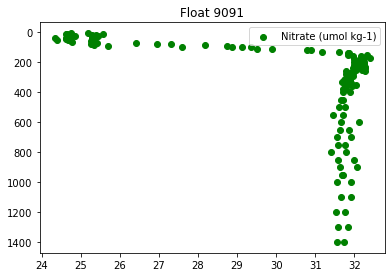

In [26]:
# Keep only good data flagged zero and replace rest with 'nan' which is "not a number"
flt['Nitrate[µmol/kg]'] = np.where(flt['QF.8'] == 0 , flt['Nitrate[µmol/kg]'], np.nan)

fig = plt.figure()
# this allows you to create multiple axes
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt['Nitrate[µmol/kg]'],flt['Pressure[dbar]'],label = 'Nitrate (umol kg-1)',color='green')
axes1.legend()
axes1.set_title('Float 9091')
axes1.invert_yaxis()
fig.savefig('F9091NitrateQC.png', dpi = 200)

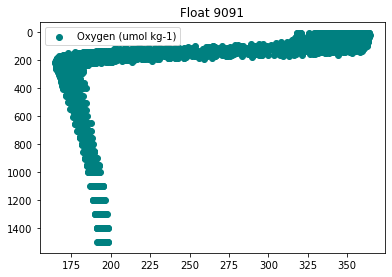

In [27]:
# is oxygen there?
# Keep only good data flagged zero and replace rest with 'nan' which is "not a number"
flt['Oxygen[µmol/kg]'] = np.where(flt['QF.6'] == 0 , flt['Oxygen[µmol/kg]'], np.nan)
fig = plt.figure()
# this allows you to create multiple axes
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt['Oxygen[µmol/kg]'],flt['Pressure[dbar]'],label = 'Oxygen (umol kg-1)',color='teal')
axes1.legend()
axes1.set_title('Float 9091')
axes1.invert_yaxis()
fig.savefig('F9091Oxygen.png', dpi = 200)

In [28]:
# Next time- we will make a contour plot to look at oxygen over time


/Users/williams/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Temperature[°C]', ylabel='Density'>

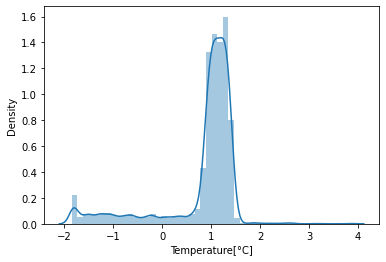

In [29]:
# Keep only good data flagged zero and replace rest with 'nan' which is "not a number"
flt['Temperature[°C]'] = np.where(flt['QF.2'] == 0 , flt['Temperature[°C]'], np.nan)
flt['Salinity[pss]'] = np.where(flt['QF.3'] == 0 , flt['Salinity[pss]'], np.nan)

sns.distplot(flt['Temperature[°C]'],kde='false')

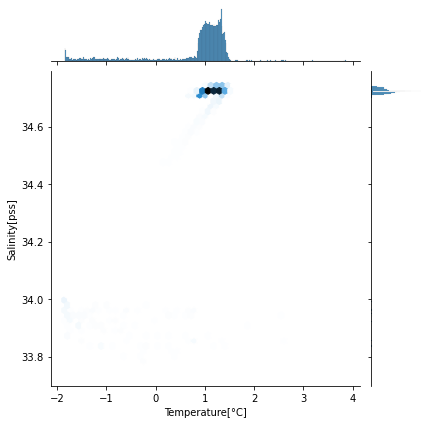

In [30]:
sns.jointplot(x='Temperature[°C]',y='Salinity[pss]',data=flt,kind='hex')

In [31]:
fltsmall=flt[['pHinsitu[Total]','Salinity[pss]','Temperature[°C]']].copy()

In [32]:
fltsmall

,pHinsitu[Total],Salinity[pss],Temperature[°C]
0,7.8557,34.7024,0.7035
1,7.8584,34.7040,0.7462
2,7.8614,34.7058,0.7919
3,7.8650,34.7084,0.8415
4,7.8688,34.7105,0.8911
...,...,...,...
84532,NaN,33.9440,-1.7620
84533,NaN,33.9440,-1.7660
84534,NaN,33.9437,-1.7654
84535,NaN,33.9440,-1.7650


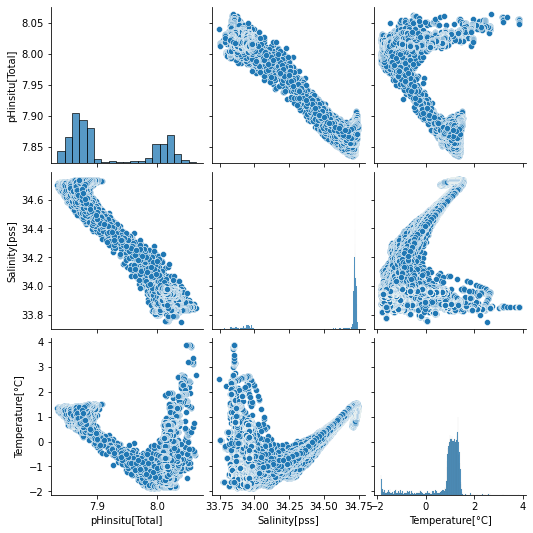

In [33]:
sns.pairplot(fltsmall)
# This will take some time. Notice the "*" that appears to the upper left while the cell runs
# If something is taking longer to run than you think it should, that's called "hanging" and
# It may be due to an error. You can quit that cell by going up to "Kernel" in the menu bar and 
# clicking "interrupt"

In [34]:
# Use this code to subsample the larger dataframe to be used with seaborn grid plots
# a=flt.pivot_table(index='Pressure[dbar]',columns='Station',values='Temperature[°C]')
# a

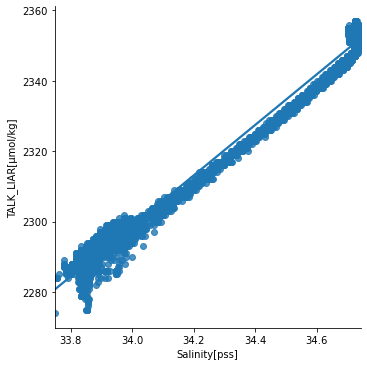

In [35]:
# Regression plots
# What is the relationsihp between TALK and S? Do you think that Alkalinity can be estimated from just salinity?
sns.lmplot(x='Salinity[pss]',y='TALK_LIAR[µmol/kg]',data=flt)

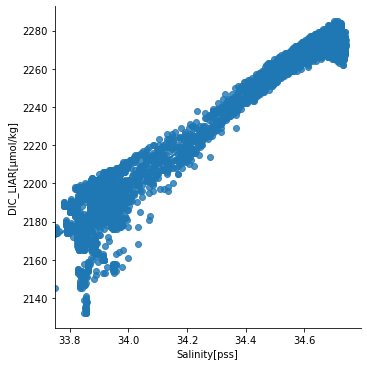

In [36]:
sns.lmplot(x='Salinity[pss]',y='DIC_LIAR[µmol/kg]',data=flt) #Seaborn linear model plot

<AxesSubplot:xlabel='Salinity[pss]', ylabel='DIC_LIAR[µmol/kg]'>

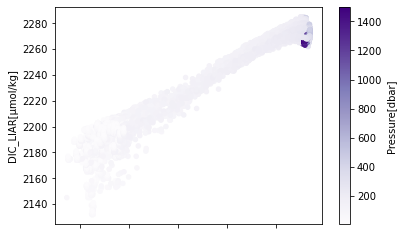

In [37]:
# What are these two different blobs? Plot a third variable as a color
flt.plot.scatter(x='Salinity[pss]',y='DIC_LIAR[µmol/kg]',c='Pressure[dbar]',cmap='Purples')

In [38]:
flt_by_station=flt.groupby('Station').mean()

In [39]:
flt_by_station

,Cruise,Lon [°E],Lat [°N],QF,Pressure[dbar],QF.1,Temperature[°C],QF.2,Salinity[pss],QF.3,...,pHinsitu[Total],QF.14,pH25C[Total],QF.15,TALK_LIAR[µmol/kg],QF.16,DIC_LIAR[µmol/kg],QF.17,pCO2_LIAR[µatm],QF.18
Station,,,,,,,,,,,,,,,,,,,,,
1,5904184,209.965,-63.973,0,474.323924,0.0,0.923189,0.0,34.597952,0.0,...,7.913916,0.884268,7.572884,0.884268,2330.031250,0.884268,2243.734375,0.884268,523.440625,0.884268
2,5904184,210.197,-63.803,0,472.502405,0.0,0.939812,0.0,34.597379,0.0,...,7.900197,0.884268,7.560975,0.884268,2329.968750,0.884268,2248.046875,0.884268,542.021875,0.884268
3,5904184,210.602,-63.676,0,472.491180,0.0,0.894548,0.0,34.597913,0.0,...,7.900670,0.883848,7.560700,0.883848,2330.296875,0.883848,2251.328125,0.883848,541.800000,0.883848
4,5904184,210.603,-63.540,0,473.447347,0.0,0.882780,0.0,34.598625,0.0,...,7.900050,0.884477,7.559675,0.884477,2330.562500,0.884477,2251.828125,0.884477,542.782813,0.884477
5,5904184,210.558,-63.480,0,475.255533,0.0,0.800222,0.0,34.587015,0.0,...,7.904355,0.882459,7.561826,0.882459,2329.723077,0.882459,2250.384615,0.882459,535.546154,0.882459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,5904184,215.753,-63.224,0,474.009134,0.0,0.780752,0.0,34.572716,0.0,...,7.930508,0.882671,7.585214,0.882671,2328.307692,0.882671,2240.584615,0.882671,502.152308,0.882671
150,5904184,216.111,-63.434,0,478.854672,0.0,0.849845,0.0,34.581030,0.0,...,7.925132,0.892336,7.583717,0.892336,2331.372881,0.892336,2243.898305,0.892336,507.359322,0.892336
151,5904184,216.688,-63.575,0,479.832568,0.0,0.793802,0.0,34.580589,0.0,...,7.928137,0.892532,7.584780,0.892532,2331.355932,0.892532,2243.644068,0.892532,503.188136,0.892532


In [40]:
# To make a contour plot with irregularly-spaced data, you must first define your grid
# What should your grid look like for a section plot?
# The y-axis should be depth, and the x-axis should be time
xi = pd.date_range(flt['date'].min(), flt['date'].max(), freq='10D')
yi = np.linspace(0, 2000, 201)
# Now we need to take the oxygen data and interpolate it onto that grid using its original x's and y's
# Griddata does not want NaNs
flt = flt[np.isfinite(flt['Oxygen[µmol/kg]'])]
grid = np.meshgrid(xi,yi)
from scipy.interpolate import griddata
grid_z = griddata((flt['date'], flt['Pressure[dbar]']), flt['Oxygen[µmol/kg]'], grid, method = 'linear')

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 2 is coplanar with the interior point)

While executing:  | qhull d Q12 Qz Qt Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1900583645  delaunay  Q12-allow-wide  Qz-infinity-point  Qtriangulate
  Qbbound-last  Qcoplanar-keep  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 1.4e+17  Error-roundoff 2.1e+03  _one-merge 1.5e+04
  Visible-distance 4.3e+03  U-max-coplanar 4.3e+03  Width-outside 8.5e+03
  _wide-facet 2.6e+04  _maxoutside 1.7e+04

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p9691(v4): 1.5e+18 3.6e+02 1.5e+18
- p9690(v3): 1.5e+18   5.5 9.6e+17
- p9626(v2): 1.5e+18 1.5e+03 9.6e+17
- p0(v1): 1.4e+18 1.4e+03     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.1e+03.  The center point, facets and distances
to the center point are as follows:

center point 1.481e+18    816.6 8.642e+17

facet p9690 p9626 p0 distance= -3.7e+16
facet p9691 p9626 p0 distance= -3.7e+02
facet p9691 p9690 p0 distance= -3.7e+02
facet p9691 p9690 p9626 distance= -6.2e+16

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:  1.397e+18  1.532e+18  difference= 1.354e+17
  1:      3.84      1500  difference= 1496
  2:         0  1.532e+18  difference= 1.532e+18

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 2.1e+03.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


In [ ]:
# NEXT: Try to use xarray to explore float data
# start with Ryan Abernathy's xarray lesson: 
# https://github.com/rabernat/research_computing/blob/master/content/lectures/python/xarray.ipynb
# Play with cookie-cutter project reproducibility tools from Julius Busecke
# Play with sea-py, mayavi
# http://www.pyngl.ucar.edu/
# https://docs.enthought.com/mayavi/mayavi/installation.html
# https://www.itsonlyamodel.us/argovis-python-api-2.html#section_two

# Machine Learning
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018JC014629

# importing CMIP6 data https://towardsdatascience.com/a-quick-introduction-to-cmip6-e017127a49d3